# Options to coarsen velocity and add different levels of noise


In [1]:
from __future__ import print_function, division
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import xarray as xr
import pickle
#import cmocean
import matplotlib.colors as colors

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [2]:
def zc():
    return np.array([-481.68085,-446.76865,-414.0377,-383.35178,-354.58304,-327.6118,-302.32565,-278.61935,
                           -256.39423,-235.5577,-216.02301,-197.70883,-180.5389,-164.44174,-149.3503,-135.20177,
                           -121.937225,-109.50143,-97.84261,-86.91223,-76.664764,-67.05755,-58.050587,-49.60637,
                           -41.689735,-34.267727,-27.309437,-20.785896,-14.669938,-8.9361,-3.5605056,-0.5])

def fourth_derivative(f,x,axis=0):
    """
    Takes the 4th derivative of an array using centered differencing, accuracy is O(dx)^2
    Only takes derivative in one direction
    
    INPUTS:
    f (2D arr): array of dependent variable (size nxm)
    x (1D arr): array of independent variable (size nx1 or mx1), assumes equal spacing
    axis (1 or 0): axis along which to take derivative in
    
    OUTPUTS:
    df (arr): array of size (n-4)x m or n x (m-4) of derivatives
    y (arr): array of corresponding derivative positions (y=x[2:-2])
    """
    
    df = np.ones((f.shape))*-9999.99
    dx = x[1]-x[0]
    
    for ind in range(len(x)-4):
        i = ind+2  # have to ignore first 2 points and last 2 points
        if axis==0:
            df[i,:] = (f[i+2,:]-4*f[i+1,:]+6*f[i,:]-4*f[i-1,:]+f[i-2,:])/(dx**4)
        else:
            df[:,i] = (f[:,i+2]-4*f[:,i+1]+6*f[:,i]-4*f[:,i-1]+f[:,i-2])/(dx**4)
    
    if axis==0: 
        df = df[2:-2,:]
    else:
        df = df[:,2:-2]
        
    y = x[2:-2]
    
    return df, y

def biharmonic_filter(f, y, kappa=0.062, axis=0):
    """
    computes f = f - kappa*f'''' to eliminate small scale noise
    
    INPUTS:
    f(arr): (nxm) arr of function values
    y(arr): (nx1) or (mx1) arr of position (assume equal spacing)
    kappa (float): mixing coefficient
    axis (int): axis to take 4th derivative along
    """
    
    df, y2 = fourth_derivative(f,y)
    
    if axis==0:
        signal_biharm = f[2:-2,:]-kappa*df 
    else:
        signal_biharm = f[:,2:-2]-kappa*df 
    
    return signal_biharm, y2

def read_psom_output(datadir,exp_name,t_ind):
    """
    Read PSOM outputs (full and face values) for the time indices indicated, and returns each variable
    concatenated of size (NK,NJ,NI,N_tsteps)
    
    INPUTS:

    """
    file_list = os.listdir(os.path.join(datadir,exp_name))
    file_list.sort()
    full_cdfs = [file for file in file_list if file.startswith('full_')]
    face_cdfs = [file for file in file_list if file.startswith('face_')] 
    
    print(full_cdfs[t_ind])
    nc_f = datadir + exp_name + full_cdfs[t_ind]
    DS = xr.open_dataset(nc_f)
    tr = np.array(DS.tr[:,1:-1,1:-1,1:-1])
    rho = np.array(DS.rho)[1:-1,1:-1,1:-1]  # ignore ghost points 
    vor = np.array(DS.vor)[1:-1,1:-1,1:-1]
    u = np.array(DS.u)[1:-1,1:-1,1:-1]
    v = np.array(DS.v)[1:-1,1:-1,1:-1]
    w = np.array(DS.w)[1:-1,1:-1,1:-1]
    DS.close()
    del DS
    
    print(face_cdfs[t_ind])
    nc_f = datadir + exp_name + face_cdfs[t_ind]
    DS = xr.open_dataset(nc_f)
    uf = DS.uf  # shape is (32,384,97)
    vf = DS.vf
    wf = np.array(DS.wf)*10**5 #convert to s^{-1}
    DS.close()
    del DS
        
    div = wf
        
    return [u,v,vor,rho,div,w]

def select_region(varlist, xrange=(0,-1),yrange=(0,151), k0=31):
    """
    Clip array to only include region of interest
    """
    X = varlist[0:-1]
    Y = varlist[-1]
    
    inputs = []
    for var in X: # loop over all input
        inputs.append(var[k0,yrange[0]:yrange[1],xrange[0]:xrange[1]])
    
    outputs = Y[:,yrange[0]:yrange[1],xrange[0]:xrange[1]]
    
    return (inputs, outputs)

def cross_shore_diff(var):
    """
    Calculate the difference of a variable from its location at y=L
    var(arr): 2D array with dimensions (NJ,NI)
    L(int): index for offshore location
    """
    L = np.shape(var)[0]
    var_offshore = np.repeat(var[-1,:][np.newaxis,:],L,axis=0)
    dvar = var-var_offshore
    return dvar

def cross_shore_gradient(var,dy):
    """
    Calculate the gradient of a variable in the cross-shore direction
    var(arr): 2D array with dimensions (NJ,NI)
    dy(float): grid spacing (in m)
    """
    dvar = (var[1:,:]-var[0:-1,:])/dy
    return dvar

def mld_N2peak(rho,threshold=0.03,li=2,ui=4,xs_extent=151,zc = zc()):
    """
    Calculates MLD using a threshold from the -10m value and interpolating to get an exact depth.
    Also returns the max N2 (depth and value) within some range above and below the MLD
    INPUTS:
    -rho (NK,NJ,NI) arr
    -threshold (float): delta rho for calculating MLD from a depth of ~-10 m (surface depth is hard-coded)
    -li (int): number of grids below MLD to search for max N2
    -ui (int): number of grids above MLD to search for max N2
    OUTPUTS:
    -mld (NJxNI arr): mixed layer depth at every point
    -N2_max (NJxNI arr): max N2 value at every point
    -N2_max_z (NJxNI arr): depth of max N2 value (should be somewhat close to MLD)
    """
    N2 = -(9.8/(1025))*np.gradient(rho,zc,axis=0)*10**4 # 2nd order accurate central differencing in interior, first order at edges
    NI = rho.shape[-1]
    rho_0 = np.tile(rho[29,:,:],(32,1,1))
    mld = np.empty((xs_extent,98))
    N2_max = np.empty((xs_extent,98))
    N2_max_z = np.empty((xs_extent,98))

    for i in range(NI):
        for j in range(xs_extent):
            a = np.where(rho[:,j,i]-rho_0[:,j,i]>threshold)[0][-1] 
            b = a+1
            z_interp = np.arange(zc[a],zc[b],0.1)
            rho_interp = np.interp(z_interp, zc[a:b+1], rho[a:b+1,j,i])
            mld_ind = np.where(rho_interp>threshold)[0][-1]
            mld[j,i] = z_interp[mld_ind]

            N2_max[j,i] = np.max(N2[b-li:b+ui,j,i])
            N2_max_z[j,i]=zc[b-li+np.argmax(N2[b-li:b+ui,j,i])]

    return mld, N2_max, N2_max_z

def coarsen(feature, res):
    """
    INPUTS:
    -feature (arr) of size NJxNI
    -res (int): number of grid points to average together
    OUTPUTS:
    returns an array of size (NJ-NJ%res,NI-NI%res) which is a coarsed version of feature
    """
    NJ = feature.shape[0]
    NI = feature.shape[1]

    feature_coarse = np.empty((NJ,NI))

    for j in range(0,feature.shape[0],res):
        for i in range(0,feature.shape[1],res):
            feature_coarse[j:j+res,i:i+res] = np.median(feature[j:j+res,i:i+res])

    return feature_coarse[:NJ-(NJ%res),:NI-(NI%res)] # chop off end columns/rows that weren't used

def reshape_var(input_list, output_list):
    """
    reshapes variables at one snapshot in time
    
    INPUTS: 
    -input_list: list of variable arrays (list items are NJxNI arrays), e.g. X_filtered
    -output_list: list of output arrays (list elements are NJxNI arrays), e.g. Y_filtered
  
    OUTPUTS:
    -X (arr): size (num_pts, num_features/variables, 1)
    -Y (arr): size (num_pts, num_depths, 1)
    """
    first=True
    for w in output_list:
        if first:
            Y = np.reshape(w,(w.size,1,1))
            first=False
        else:
            y_temp = np.reshape(w,(w.size,1,1))
            Y = np.hstack((Y,y_temp))
            
    first = True
    for var in input_list:
        if first:
            X = np.reshape(var,(var.size,1,1))
            first = False
        else:
            x_temp = np.reshape(var,(var.size,1,1))
            X = np.hstack((X,x_temp))
            
    return X,Y

def divergence(u,v):
    """
    -Inputs: u & v (arr) size (NJ,NI)
    -Output: divergence (arr) size (NJ-2,NI-2)
    -assume dx, dy = 1km
    -uses centered differencing
    """
    dx = 1 # m, grid resolution
    dy = 1 # m, grid resolution
    
    dudx = (u[:,2:]-u[:,0:-2])/(2*dx)
    dvdy = (v[2:,:]-v[0:-2,:])/(2*dx)
    
    div = dudx[1:-1,:]+dvdy[:,1:-1]
    return div

def vorticity(u,v):
    """
    -Inputs: u & v (arr) size (NJ,NI)
    -Output: vorticity (arr) size (NJ-2,NI-2)
    -assume dx, dy = 1km
    -uses centered differencing
    """
    dx = 1 # m, grid resolution
    dy = 1 # m, grid resolution
    
    dvdx = (v[:,2:]-v[:,0:-2])/(2*dx)
    dudy = (u[2:,:]-u[0:-2,:])/(2*dy)
    
    vor = dvdx[1:-1,:]-dudy[:,1:-1]
    return vor


def A_theta_noise(U,V,noise_level):
    """
    Inputs: U,V (arr) size (NJ,NI)
    Outputs: unoise,vnoise (arr) size (NJ,NI)
    -applies white noise to A and theta, where u=Acos(theta) and v = Asin(theta)
    """
    A = (U**2+V**2)**(0.5)
    theta = np.arctan2(V,U)

    # create random noise (between 0 & 1)
    A_noise = np.random.rand(A.shape[0],A.shape[1])*noise_level*A
    theta_noise = (np.random.rand(theta.shape[0],theta.shape[1])-0.5)*noise_level*3.14159#np.mean(theta) 

    u2 = (A+A_noise)*np.cos(theta+theta_noise)
    v2 = (A+A_noise)*np.sin(theta+theta_noise)
    return u2,v2

In [3]:
 def smooth_psom(datadir, exp, day, L=155, k0=31, noise_level=0, res = 1):
    """
    Reads in a model snapshot, selects cross-shore region and applies a biharmonic filter to smooth out grid-scale noise.
    
    Returns a list of inputs X and outputs Y
    
    feat = ['u','v','vor','drho','div','MLD','N2_max','drho_dy','drho_dx','grad_rho_mag']
    """
    var_list = read_psom_output(datadir, exp, day)

    X,Y = select_region(var_list, xrange=(0,-1),yrange=(0,L), k0=k0) # X is a list of feature arrays, Y is a 3D array of outputs

    y = np.arange(L)
    X_filtered=[]
    Y_filtered=[]
    for var in X:
        xf,yf = biharmonic_filter(var, y, kappa=0.062, axis=0)
        X_filtered.append(xf)  # X_filtered is a list of each feature array

    for k in range(Y.shape[0]):
        wf,yf = biharmonic_filter(Y[k,:,:],y,kappa=0.062,axis=0)
        Y_filtered.append(wf)  # Y_filtered is a list of length 32 (length of depth)

    # add MLD and N2 to X_filtered
    NJ, NI = X_filtered[0].shape
    rho = var_list[3] # want full 3D field
    #print(rho.shape)
    mld, N2_max, N2_max_z = mld_N2peak(rho,threshold=0.03,li=2,ui=4,xs_extent=L)
    #print(mld[:NJ,:NI].shape)
    #print(N2_max[:NJ,:NI].shape)
    X_filtered.extend([mld[:NJ,:NI],N2_max[:NJ,:NI]])
    
    ## calculate drho from rho
    grad_rho = np.gradient(X_filtered[3]) #cross_shore_gradient(X_filtered[3],1) # units of density/km
    grad_mag = (grad_rho[0]**2 + grad_rho[1]**2)**0.5
    X_filtered.extend([grad_rho[0],grad_rho[1],grad_mag])
    X_filtered[3] = cross_shore_diff(X_filtered[3])
    
## coarsen u & v
    inds = [0,1]#,2,4] # features in X_filtered to coarsen
    for ind in inds:
        feature = X_filtered[ind]
        feature_coarsened = coarsen(feature,res)
        X_filtered[ind]=feature_coarsened
        NJ_new = feature_coarsened.shape[0]-1 # subtract one for grad_rho
        NI_new = feature_coarsened.shape[1]
    # make all features the same size as coarsened ones
    for x in range(len(X_filtered)):
        X_filtered[x] = X_filtered[x][:NJ_new,:NI_new]
    for y in range(len(Y_filtered)):
        Y_filtered[y] = Y_filtered[y][:NJ_new,:NI_new]
        
    ## noisy velocities, replace u & v with noisy velocities and re-calculate divergence
    if noise_level>0:
        print('adding noise')
        U = X_filtered[0]
        V = X_filtered[1]
        u2,v2 = A_theta_noise(U,V,noise_level)
        div2 = divergence(u2,v2)
        vor2 = vorticity(u2,v2)  
        X_filtered[0]=u2
        X_filtered[1]=v2
        X_filtered[4]=div2
        X_filtered[2]=vor2
        
        # make all features same size, lose 1 grid point in horizontal directions from divergence & vorticity calculation
        for ind in range(len(X_filtered)):
            if ind != 2 and ind !=4: # vor and div already reduced dimensions
                X_filtered[ind] = X_filtered[ind][1:-1,1:-1]
            

    return X_filtered, Y_filtered

In [4]:
def plot_input(X, ind = 1, cmap = 'viridis'):
    """
    X is list of input data, each element of X is a 2D variable slice of size (NJ x NI)
    """
    f = 0.376*10**(-4)

    feat = ['u','v','vor','drho','div','drho_dy','drho_dx','grad_rho_mag']
    labels=['u (m/s)','v (m/s)',r'$\zeta/f$',r'$\Delta\rho$ (kg/m$^3$)',r'$\nabla_H \cdot \vec{u}$  (s$^{-1}$)',
            r'$\frac{\partial \rho}{\partial y}$(kg/m$^3$/km)',r'$\frac{\partial \rho}{\partial x}$(kg/m$^3$/km)',
            r'$|\nabla \rho|$ (kg/m$^3$/km)']

    text_font={'family': 'sans-serif', 'fontsize': 16, 'fontweight': 'normal'}
    #savefigdir='/Users/jing/Desktop/' 

    plt.figure(figsize=(8,5))
    if ind==2:
        midnorm = MidpointNormalize(vmin=-2, vcenter=0, vmax=6) 
        plt.imshow(X[ind].T/f,cmap='bwr', norm=midnorm)
    else:
        #midnorm = MidpointNormalize(vmin=-.15, vcenter=0, vmax=0.1) # for divergence
        plt.imshow(X[ind].T,cmap=cmap)

    plt.xlim([149,0])
    plt.ylim([0,95])
    plt.xlabel('cross-shore (km)',fontdict=text_font)
    plt.ylabel('along-shore (km)',fontdict=text_font)
    plt.tick_params(axis='both', which='major', labelsize=16)

    c=plt.colorbar(aspect=25, pad=0.03,shrink=0.85)
    c.set_label(labels[ind],fontdict=text_font)
    c.ax.tick_params(labelsize=14)


def plot_output(Y, ind=25, zc=zc()):
    c = 1 #to convert from mm/s to m/day
    print(zc[ind])

    text_font={'family': 'sans-serif', 'fontsize': 16, 'fontweight': 'normal'}
    #savefigdir='/Users/jing/Dropbox (MIT)/Research_ch2/figures/calypso/rf inputs/'

    plt.figure(figsize=(8,5))
    midnorm = MidpointNormalize(vmin=-7*c, vcenter=0*c, vmax=1.5*c) 
    plt.imshow(Y[ind].T*c,cmap='bwr',norm=midnorm)

    plt.xlim([149,0])
    plt.ylim([0,95])
    plt.xlabel('cross-shore (km)',fontdict=text_font)
    plt.ylabel('along-shore (km)',fontdict=text_font)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.title('z=%i m'%zc[ind],fontsize=20)

    c=plt.colorbar(aspect=25, pad=0.03,shrink=0.85)
    c.set_label('w (mm/s)',fontdict=text_font)
    c.ax.tick_params(labelsize=14)

## Next to do, divide up input data into NxN images

And find corresponding Y (located at the center of each NxN image)

In [5]:
def crop_image(X, Y, n=32):
    """
    X,Y are lists (result of smooth_psom)
    n is size of sample
    """
    Xarr = np.array(X)
    Yarr = np.array(Y)

    y_profiles = []
    x_imgs = []
    centers = []
    i1 = []
    i2 = []
    j1 = []
    j2 = []
    
    # loop over every grid point (shift over 1 grid point, shift up a grid point...)
    for i in range(Xarr.shape[2]-n-1):
        for j in range(Xarr.shape[1]-n-1):
            # crop out part of image
            xcrop = Xarr[:,j:j+n,i:i+n] # shape (NUM_VAR, n, n)
            ycrop = Yarr[:,j:j+n,i:i+n] # shape (NK, n, n)

            # output is approx at center of cropped image
            y_val = ycrop[:,int(n/2),int(n/2)] # shape (NK, 1)

            x_imgs.append(xcrop)
            y_profiles.append(y_val)
            
            i1.append(i)
            i2.append(i+n)
            j1.append(j)
            j2.append(j+n)
            centers.append((j+int(n/2),i+int(n/2)))
            
    
    return x_imgs, y_profiles, centers, (i1,i2,j1,j2)

In [6]:
def plot_xcrop(xcrop,save=False, savefigdir='/Users/jing/Dropbox (MIT)/Thesis/Research_ch2/figures/CNN/training_samples',
               figname='test'):
    
    feat =  ['u (m/s)','v (m/s)',r'$\zeta/f$',r'$\Delta\rho$ (kg/m$^3$)',r'$\nabla_H \cdot \vec{u}$  (s$^{-1}$)',
             'MLD (m)', r'N2$_{max}$ (s$^{-2}$)',
            r'$\frac{\partial \rho}{\partial y}$(kg/m$^3$/km)',r'$\frac{\partial \rho}{\partial x}$(kg/m$^3$/km)',
            r'$|\nabla \rho|$ (kg/m$^3$/km)']
    
    cmaps = ['viridis','viridis','bwr','PuRd','bwr',
            'inferno','inferno','PuOr']
    
    n = 32
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), 
                             subplot_kw={'xticks': [], 'yticks': []})
    
    fig.subplots_adjust(hspace=0.3, wspace=0.05)
    
    for ax, feat, cropped_var, cmap in zip(axes.flat, feat, xcrop[:], cmaps):
        ax.imshow(cropped_var.T,cmap=cmap)
        ax.set_xlim([n-1,0])
        ax.set_ylim([0,n-1])
        ax.plot(int(n/2),int(n/2),'ro')
        ax.set_title(feat)
    
    if save:
        plt.savefig(os.path.join(savefigdir, figname+'.png'), bbox_inches='tight',dpi=300)
        plt.close()

# Put it together and load data from 1 day across 9 models

In [7]:
!pwd

/vortexfs1/share/mahadevanlab/jing/cnn


In [8]:
noise_levels= [0]
res = 5
days = [0, 5, 10, 15, 20]

for noise_level in noise_levels:
    for day in days:
        datadir = '/vortexfs1/share/mahadevanlab/jing/PSOM_outputs/source depth paper/'
        sims = ['g-W1d-1_NN1d-4/','g-W1d-1_NN1d-5/','g-W1d-1_NN5d-5/',
                'g-W1d-2_NN1d-4/','g-W1d-2_NN1d-5/','g-W1d-2_NN5d-5/',
                'g-W5d-2_NN1d-4/','g-W5d-2_NN1d-5/','g-W5d-2_NN5d-5/']

        start_days = [35, 35, 28, 115, 87, 140, 68, 29, 51]

        L = 155
        n=32

        X = []
        Y = []
        centers = []
        coords_i1 = []
        coords_i2 = []
        coords_j1 = []
        coords_j2 = []
        exps = []

        for exp, start in zip(sims, start_days):
            print(exp)

            X1, Y1 = smooth_psom(datadir, exp, start+day, L=155, k0=31, noise_level=noise_level, res = res)
            X2, Y2, center, coord = crop_image(X1, Y1, n=32) # returns a list    

            X.extend(X2)
            Y.extend(Y2)
            centers.extend(center)
            coords_i1.extend(coord[0])
            coords_i2.extend(coord[1])
            coords_j1.extend(coord[2])
            coords_j2.extend(coord[3])
            exps.extend(([exp[:-1]]*len(X2)))

        with open('data/coarse_%ikm_day%i.pkl'%(res, day),'wb') as f:
            pickle.dump((X,Y,centers,(coords_i1, coords_i2, coords_j1, coords_j2),exps),f)

g-W1d-1_NN1d-4/
full_28000.cdf
face_28000.cdf
g-W1d-1_NN1d-5/
full_28000.cdf
face_28000.cdf
g-W1d-1_NN5d-5/
full_22400.cdf
face_22400.cdf
g-W1d-2_NN1d-4/
full_46000.cdf
face_46000.cdf
g-W1d-2_NN1d-5/
full_34800.cdf
face_34800.cdf
g-W1d-2_NN5d-5/
full_56000.cdf
face_56000.cdf
g-W5d-2_NN1d-4/
full_27200.cdf
face_27200.cdf
g-W5d-2_NN1d-5/
full_11600.cdf
face_11600.cdf
g-W5d-2_NN5d-5/
full_20400.cdf
face_20400.cdf
g-W1d-1_NN1d-4/
full_32000.cdf
face_32000.cdf
g-W1d-1_NN1d-5/
full_32000.cdf
face_32000.cdf
g-W1d-1_NN5d-5/
full_26400.cdf
face_26400.cdf
g-W1d-2_NN1d-4/
full_48000.cdf
face_48000.cdf
g-W1d-2_NN1d-5/
full_36800.cdf
face_36800.cdf
g-W1d-2_NN5d-5/
full_58000.cdf
face_58000.cdf
g-W5d-2_NN1d-4/
full_29200.cdf
face_29200.cdf
g-W5d-2_NN1d-5/
full_13600.cdf
face_13600.cdf
g-W5d-2_NN5d-5/
full_22400.cdf
face_22400.cdf
g-W1d-1_NN1d-4/
full_36000.cdf
face_36000.cdf
g-W1d-1_NN1d-5/
full_36000.cdf
face_36000.cdf
g-W1d-1_NN5d-5/
full_30400.cdf
face_30400.cdf
g-W1d-2_NN1d-4/
full_50000.cdf
fac

In [94]:
noise_levels= [0.01, 0.05, 0.1]
days = [0, 5, 10, 15, 20]

for noise_level in noise_levels:
    for day in days:
        datadir = '/vortexfs1/share/mahadevanlab/jing/PSOM_outputs/source depth paper/'
        sims = ['g-W1d-1_NN1d-4/','g-W1d-1_NN1d-5/','g-W1d-1_NN5d-5/',
                'g-W1d-2_NN1d-4/','g-W1d-2_NN1d-5/','g-W1d-2_NN5d-5/',
                'g-W5d-2_NN1d-4/','g-W5d-2_NN1d-5/','g-W5d-2_NN5d-5/']

        start_days = [35, 35, 28, 115, 87, 140, 68, 29, 51]

        L = 155
        n=32

        X = []
        Y = []
        centers = []
        coords_i1 = []
        coords_i2 = []
        coords_j1 = []
        coords_j2 = []
        exps = []

        for exp, start in zip(sims, start_days):
            print(exp)

            X1, Y1 = smooth_psom(datadir, exp, start+day, L=155, k0=31, noise_level=noise_level)
            X2, Y2, center, coord = crop_image(X1, Y1, n=32) # returns a list    

            X.extend(X2)
            Y.extend(Y2)
            centers.extend(center)
            coords_i1.extend(coord[0])
            coords_i2.extend(coord[1])
            coords_j1.extend(coord[2])
            coords_j2.extend(coord[3])
            exps.extend(([exp[:-1]]*len(X2)))

        #with open('data/noisy_uv_%iper_day%i.pkl'%(noise_level*100, day),'wb') as f:
        #    pickle.dump((X,Y,centers,(coords_i1, coords_i2, coords_j1, coords_j2),exps),f)

g-W1d-1_NN1d-4/
full_28000.cdf
g-W1d-1_NN1d-4/
full_28000.cdf
face_28000.cdf
face_28000.cdf
adding noise
g-W1d-1_NN1d-5/
full_28000.cdf
adding noise
g-W1d-1_NN1d-5/
full_28000.cdf
face_28000.cdf
face_28000.cdf
adding noise
g-W1d-1_NN5d-5/
full_22400.cdf
adding noise
g-W1d-1_NN5d-5/
full_22400.cdf
face_22400.cdf
face_22400.cdf
adding noise
g-W1d-2_NN1d-4/
full_46000.cdf
adding noise
g-W1d-2_NN1d-4/
full_46000.cdf
face_46000.cdf
face_46000.cdf
adding noise
g-W1d-2_NN1d-5/
full_34800.cdf
adding noise
g-W1d-2_NN1d-5/
full_34800.cdf
face_34800.cdf
face_34800.cdf
adding noise
g-W1d-2_NN5d-5/
full_56000.cdf
adding noise
g-W1d-2_NN5d-5/
full_56000.cdf
face_56000.cdf
face_56000.cdf
adding noise
g-W5d-2_NN1d-4/
full_27200.cdf
adding noise
g-W5d-2_NN1d-4/
full_27200.cdf
face_27200.cdf
face_27200.cdf
adding noise
g-W5d-2_NN1d-5/
full_11600.cdf
adding noise
g-W5d-2_NN1d-5/
full_11600.cdf
face_11600.cdf
face_11600.cdf
adding noise
g-W5d-2_NN5d-5/
full_20400.cdf
adding noise
g-W5d-2_NN5d-5/
full_2040

face_31200.cdf
face_31200.cdf
adding noise
g-W5d-2_NN1d-5/
full_15600.cdf
adding noise
g-W5d-2_NN1d-5/
full_15600.cdf
face_15600.cdf
face_15600.cdf
adding noise
g-W5d-2_NN5d-5/
full_24400.cdf
adding noise
g-W5d-2_NN5d-5/
full_24400.cdf
face_24400.cdf
face_24400.cdf
adding noise
adding noise
g-W1d-1_NN1d-4/
full_40000.cdf
g-W1d-1_NN1d-4/
full_40000.cdf
face_40000.cdf
face_40000.cdf
adding noise
g-W1d-1_NN1d-5/
full_40000.cdf
adding noise
g-W1d-1_NN1d-5/
full_40000.cdf
face_40000.cdf
face_40000.cdf
adding noise
g-W1d-1_NN5d-5/
full_34400.cdf
adding noise
g-W1d-1_NN5d-5/
full_34400.cdf
face_34400.cdf
face_34400.cdf
adding noise
g-W1d-2_NN1d-4/
full_52000.cdf
adding noise
g-W1d-2_NN1d-4/
full_52000.cdf
face_52000.cdf
face_52000.cdf
adding noise
g-W1d-2_NN1d-5/
full_40800.cdf
adding noise
g-W1d-2_NN1d-5/
full_40800.cdf
face_40800.cdf
face_40800.cdf
adding noise
g-W1d-2_NN5d-5/
full_62000.cdf
adding noise
g-W1d-2_NN5d-5/
full_62000.cdf
face_62000.cdf
face_62000.cdf
adding noise
g-W5d-2_NN1d-

In [9]:
print(len(X))
print(len(Y))
print(len(coords_i1))
print(len(coords_i2))
print(len(coords_j1))
print(len(coords_j2))
print(len(exps))

64728
64728
64728
64728
64728
64728
64728


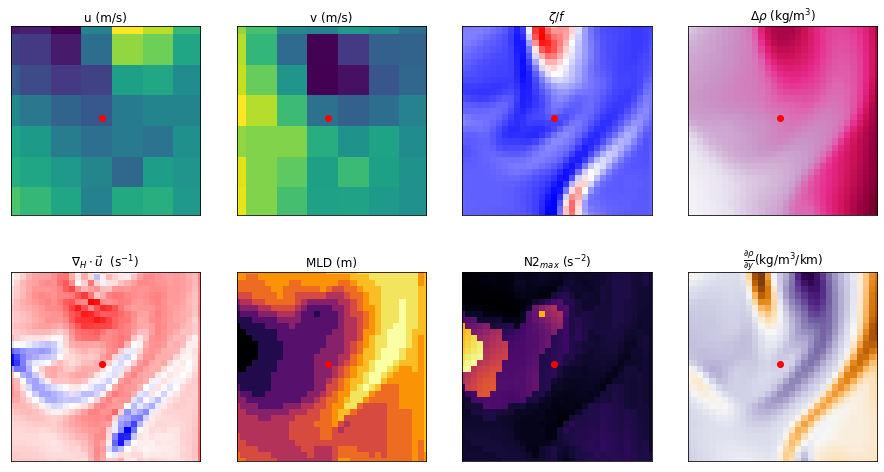

In [10]:
plot_xcrop(X[0],save=False)

In [ ]:
with open('data/day5_noisy_uv_10per.pkl','wb') as f:
    pickle.dump((X,Y,centers,(coords_i1, coords_i2, coords_j1, coords_j2),exps),f)

In [ ]:
class psom_data(Dataset):
    """creates dataset from model outputs for training based on list of simulations to use and
       range of days to include"""

    def __init__(self, datadir='data/', days=(5,10), var = (0,1,3,5,6), transform=None, standardize=True, basic=True):
        """
        Args:
            datadir (string): path to model outputs
            day (int): which day of analysis period to use (start_day + day)
            var (tuple): indices of variables to use
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """     
        X = []; Y = []; center = []; exp = []; day_list = [];
        i1 = []; i2 = []; j1 = []; j2 = []
        
        for day in days:
            with open(os.path.join(datadir,'day%i_mld_n2.pkl'%day),'rb') as f:
                X_temp, Y_temp, center_temp, coord_temp, exp_temp = pickle.load(f)
        
            X.extend(X_temp); Y.extend(Y_temp); center.extend(center_temp); 
            i1.extend(coord_temp[0]); i2.extend(coord_temp[1]);
            j1.extend(coord_temp[2]); j2.extend(coord_temp[3]);
            exp.extend(exp_temp); day_list.extend([day]*len(X_temp))
                
        if standardize:
            Xarr = np.array(X)
            mean = np.mean(Xarr, axis=(0,2,3), keepdims=True)
            std = np.std(Xarr, axis=(0,2,3), keepdims=True)
            X = (Xarr-mean)/std
            
        self.X = X # list of inputs, each sample has dim (N_var, n, n)
        self.Y = Y # list of outputs, each sample has dim (depth,)
        self.center = center
        self.i1 = i1
        self.i2 = i2
        self.j1 = j1
        self.j2 = j2
        self.exp = exp
        self.transform = transform
        self.basic=basic
        self.day = day_list
        self.var = var

    def __len__(self):
        assert len(self.X)==len(self.Y), 'X and Y must have the same lengths'
        assert len(self.exp)==len(self.i1), 'coordinates and experiments must have same lengths'
        assert len(self.i1)==len(self.i2)==len(self.j1)==len(self.j2), 'coordinates must have same lengths'
        return len(self.X)  

    def __getitem__(self, idx):
        if self.transform:
            sample = self.transform(sample)
            
        sample = {'X': self.X[idx][self.var,:,:], 'Y': self.Y[idx], 'center': self.center[idx],
          'coord1': (self.j1[idx], self.i1[idx]), 'coord2': (self.j2[idx], self.i2[idx]), 'exp': self.exp[idx]}
            
        if self.basic:
            return sample['X'],sample['Y']
        else:
            return sample['X'], sample['Y'], sample['center'], sample['coord1'], sample['coord2'], sample['exp']

In [ ]:
dataset = psom_data(datadir='data', days=[10], basic=False)

In [ ]:
xtest, ytest, center, coord1, coord2, exp = dataset[100]


In [ ]:
print(xtest.shape)

In [ ]:
print(np.mean(xtest[4]))

In [ ]:
print(len(dataset))

In [ ]:
#x1, y1, center, c1, c2, e = dataset[60000]
x1, y1 = dataset[60000]

In [ ]:
print(len(dataset))
print(x1.shape)
print(y1.shape)

In [ ]:
plot_xcrop(x1,save=False)

In [ ]:
plt.figure(figsize=(4,6))
plt.plot(y1,zc())
plt.xlabel('w (mm/s)')
plt.ylabel('z (m)');